In [ ]:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Sat Sep 11 17:57:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

In [5]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [6]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/TRAIN.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(), train_df.shape

(       pmid  ...                                     Title&Keywords
 0  32265202  ...  Ocular manifestation hospitalised patient conf...
 1  33036702  ...  COVID-19 senior Findings lesson mass screening...
 2  32406522  ...  COVID-19 Focus lung forget gastrointestinal tr...
 3  32599534  ...  subcutaneous insulin administration adequate m...
 4  33005463  ...  First Case COVID-19-Associated Collapsing Glom...
 
 [5 rows x 13 columns], (30738, 13))

In [7]:
LABEL_COLUMNS = train_df.columns.tolist()[5:-1]

In [8]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [9]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
# Ref 2.0 : lordtt13/COVID-SciBERT
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


In [13]:
MAX_TOKEN_COUNT = 512

In [14]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [15]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [16]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [17]:
%pwd

'/content'

In [18]:
val_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/VAL.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(3423, 13)

In [19]:
N_EPOCHS = 10
BATCH_SIZE = 4

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [20]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[6.109995635093846, 1.8774141630901287, 9.160994764397905, 2.5855190247506465, 1.0, 4.4227488151658765, 1.3871766921018729]


In [21]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 6.109995635093846,
 'Diagnosis': 1.8774141630901287,
 'Epidemic Forecasting': 9.160994764397905,
 'Mechanism': 2.5855190247506465,
 'Prevention': 1.0,
 'Transmission': 4.4227488151658765,
 'Treatment': 1.3871766921018729}

In [22]:
class_weight = torch.tensor(class_weight, device="cuda")

In [23]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)

    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, input_ids, attention_mask, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # last_hidden_state (batch_size x sequence_length x hidden_size)
    encoded_output = bert_outputs.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(encoded_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, encoded_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))

    # output = self.classifier(output.pooler_output)
    # output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [24]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [25]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(15368, 76840)

In [26]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
%pwd

'/content'

In [ ]:
# cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'
%cd '/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/'

/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="Biomednlp-lwan-checkpoints",
    filename="Biomednlp-lwan-best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("Biomednlp-lwan-lightning_logs", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | criterion  | BCELoss   | 0     
2 | fc         | Linear    | 5.4 K 
3 | relu       | ReLU      | 0     
4 | softmax    | Softmax   | 0     
5 | classifier | Linear    | 769   
6 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.954   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 7684: val_loss reached 0.41809 (best 0.41809), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/Biomednlp-lwan-checkpoints/Biomednlp-lwan-best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 15369: val_loss reached 0.39304 (best 0.39304), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/Biomednlp-lwan-checkpoints/Biomednlp-lwan-best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 23054: val_loss reached 0.35509 (best 0.35509), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/Biomednlp-lwan-checkpoints/Biomednlp-lwan-best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 30739: val_loss reached 0.33823 (best 0.33823), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/Biomednlp-lwan-checkpoints/Biomednlp-lwan-best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 38424: val_loss was not in top 1


### Test

In [30]:
# import dataset
test_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/TEST_dataset.csv')
test_df.head()

,title,pmid,abstract,keywords
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN


In [31]:
import numpy as np

In [32]:
label_sampled = np.random.randint(0, 2, size=(test_df.shape[0], 7))
label_sampled.shape

(2500, 7)

In [33]:
test_df[LABEL_COLUMNS] = label_sampled

In [34]:
test_df.head()

,title,pmid,abstract,keywords,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN,1,0,0,1,1,1,1
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...,1,0,0,0,1,1,1
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...,0,1,0,0,1,0,0
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...,0,1,0,1,1,0,1
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN,0,1,1,1,1,1,1


In [37]:
test_df.isna().sum()

title                     0
pmid                      0
abstract                  0
keywords                444
Case Report               0
Diagnosis                 0
Epidemic Forecasting      0
Mechanism                 0
Prevention                0
Transmission              0
Treatment                 0
dtype: int64

In [36]:
test_df["abstract"] = test_df.abstract.fillna("")

In [40]:
test_df.head()

,title,pmid,abstract,keywords,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,Disentangling Association Hydroxychloroquine T...,34336157,efficacy hydroxychloroquine HCQ treating SARSC...,NaN,1,0,0,1,1,1,1
1,Risk factor mortality hospitalized patient COV...,34211701,BACKGROUND Peru one country highest COVID19 mo...,adults;covid-19;latin america.;mortality;sars-...,1,0,0,0,1,1,1
2,Inflammation COVID19 pathogenesis treatment,34367415,coronavirus disease 2019 COVID19 declared pand...,covid-19;sars-cov-2;cytokine storm;inflammatio...,0,1,0,0,1,0,0
3,Antimalarial drugsare beneficial rheumatic vir...,34218393,majority medical fraternity continuously invol...,antimalarial drugs;covid-19;rheumatic diseases...,0,1,0,1,1,0,1
4,Integration virtual physician visit provincial...,34131026,BACKGROUND British Columbia like many jurisdic...,NaN,0,1,1,1,1,1,1


In [41]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/new_checkpoints/Biomednlp-lwan-checkpoints/Biomednlp-lwan-best-checkpoint.ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
trained_model.freeze()

### Evaluation

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    test_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [47]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device)    
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/2500 [00:00<?, ?it/s]

In [48]:
pmid = test_df["pmid"]
pred_df = pd.DataFrame(predictions.numpy(), columns=LABEL_COLUMNS)
pred_df

,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment
0,0.005423,0.058001,0.001586,0.679243,0.007106,0.002198,0.990122
1,0.004062,0.977126,0.001667,0.021522,0.016698,0.003019,0.918885
2,0.005636,0.027197,0.004297,0.657994,0.013438,0.005694,0.982893
3,0.003500,0.010029,0.001295,0.442597,0.011996,0.001735,0.989488
4,0.001137,0.003588,0.000698,0.001392,0.951237,0.000907,0.014660
...,...,...,...,...,...,...,...
2495,0.012409,0.015749,0.005118,0.961209,0.022748,0.006932,0.987891
2496,0.008807,0.739806,0.001807,0.234476,0.010052,0.002785,0.976855
2497,0.007423,0.922100,0.001449,0.012991,0.628681,0.004481,0.436542
2498,0.003418,0.633947,0.001469,0.127919,0.078115,0.002280,0.956453


In [49]:
pred_df["PMID"] = pmid

In [50]:
main_pred_df = pred_df.copy(deep=True)

In [51]:
main_pred_df.columns

Index(['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism',
       'Prevention', 'Transmission', 'Treatment', 'PMID'],
      dtype='object')

In [52]:
main_pred_df = main_pred_df.reindex(['PMID','Treatment','Diagnosis','Prevention','Mechanism','Transmission','Epidemic Forecasting','Case Report'], axis="columns")
main_pred_df.head()

,PMID,Treatment,Diagnosis,Prevention,Mechanism,Transmission,Epidemic Forecasting,Case Report
0,34336157,0.990122,0.058001,0.007106,0.679243,0.002198,0.001586,0.005423
1,34211701,0.918885,0.977126,0.016698,0.021522,0.003019,0.001667,0.004062
2,34367415,0.982893,0.027197,0.013438,0.657994,0.005694,0.004297,0.005636
3,34218393,0.989488,0.010029,0.011996,0.442597,0.001735,0.001295,0.003500
4,34131026,0.014660,0.003588,0.951237,0.001392,0.000907,0.000698,0.001137


In [53]:
%cd drive/MyDrive/Biocreative/Biocreative/Test_Results/

/content/drive/MyDrive/Biocreative/Biocreative/Test_Results


In [54]:
main_pred_df.to_csv("PubMedBERT_LWAN.csv", index=False)

In [55]:
new_pred = pd.read_csv("PubMedBERT_LWAN.csv")
new_pred

,PMID,Treatment,Diagnosis,Prevention,Mechanism,Transmission,Epidemic Forecasting,Case Report
0,34336157,0.990123,0.058001,0.007106,0.679243,0.002198,0.001586,0.005423
1,34211701,0.918885,0.977126,0.016698,0.021522,0.003019,0.001667,0.004062
2,34367415,0.982893,0.027197,0.013438,0.657994,0.005694,0.004297,0.005636
3,34218393,0.989488,0.010029,0.011996,0.442597,0.001735,0.001295,0.003500
4,34131026,0.014660,0.003588,0.951237,0.001392,0.000907,0.000698,0.001137
...,...,...,...,...,...,...,...,...
2495,34291555,0.987891,0.015749,0.022748,0.961209,0.006932,0.005118,0.012409
2496,34204119,0.976854,0.739806,0.010052,0.234476,0.002785,0.001807,0.008807
2497,34228511,0.436542,0.922100,0.628681,0.012991,0.004481,0.001449,0.007423
2498,34226900,0.956453,0.633947,0.078115,0.127919,0.002280,0.001469,0.003418


#### data analysis

In [ ]:
# convert prediction in boolean labels
y_pred = (predictions > 0.65).type(torch.uint8)
y_true = labels  

In [ ]:
# count non-zero values
true_counts = y_true.count_nonzero(dim=1)
pred_counts = y_pred.count_nonzero(dim=1)

In [ ]:
# dict mapping for count -> key 
unique, counts = true_counts.unique(return_counts=True)
true_count_dict = dict(zip(unique.tolist(), counts.tolist()))
print(true_count_dict)

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}


In [ ]:
X = [1, 2, 3, 4, 5]
for label in X:
  try:
    val = true_count_dict[label]
  except Exception as e:
    true_count_dict[label] = 0

true_count_dict

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}

In [ ]:
# dict mapping for count -> key
pred_count_dict = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

for idx, value in enumerate(true_counts):
  if value == pred_counts[idx]: 
    pred_count_dict[value.tolist()] += 1
  else:
    pass

pred_count_dict

{1: 17165, 2: 5652, 3: 380, 4: 25, 5: 2}

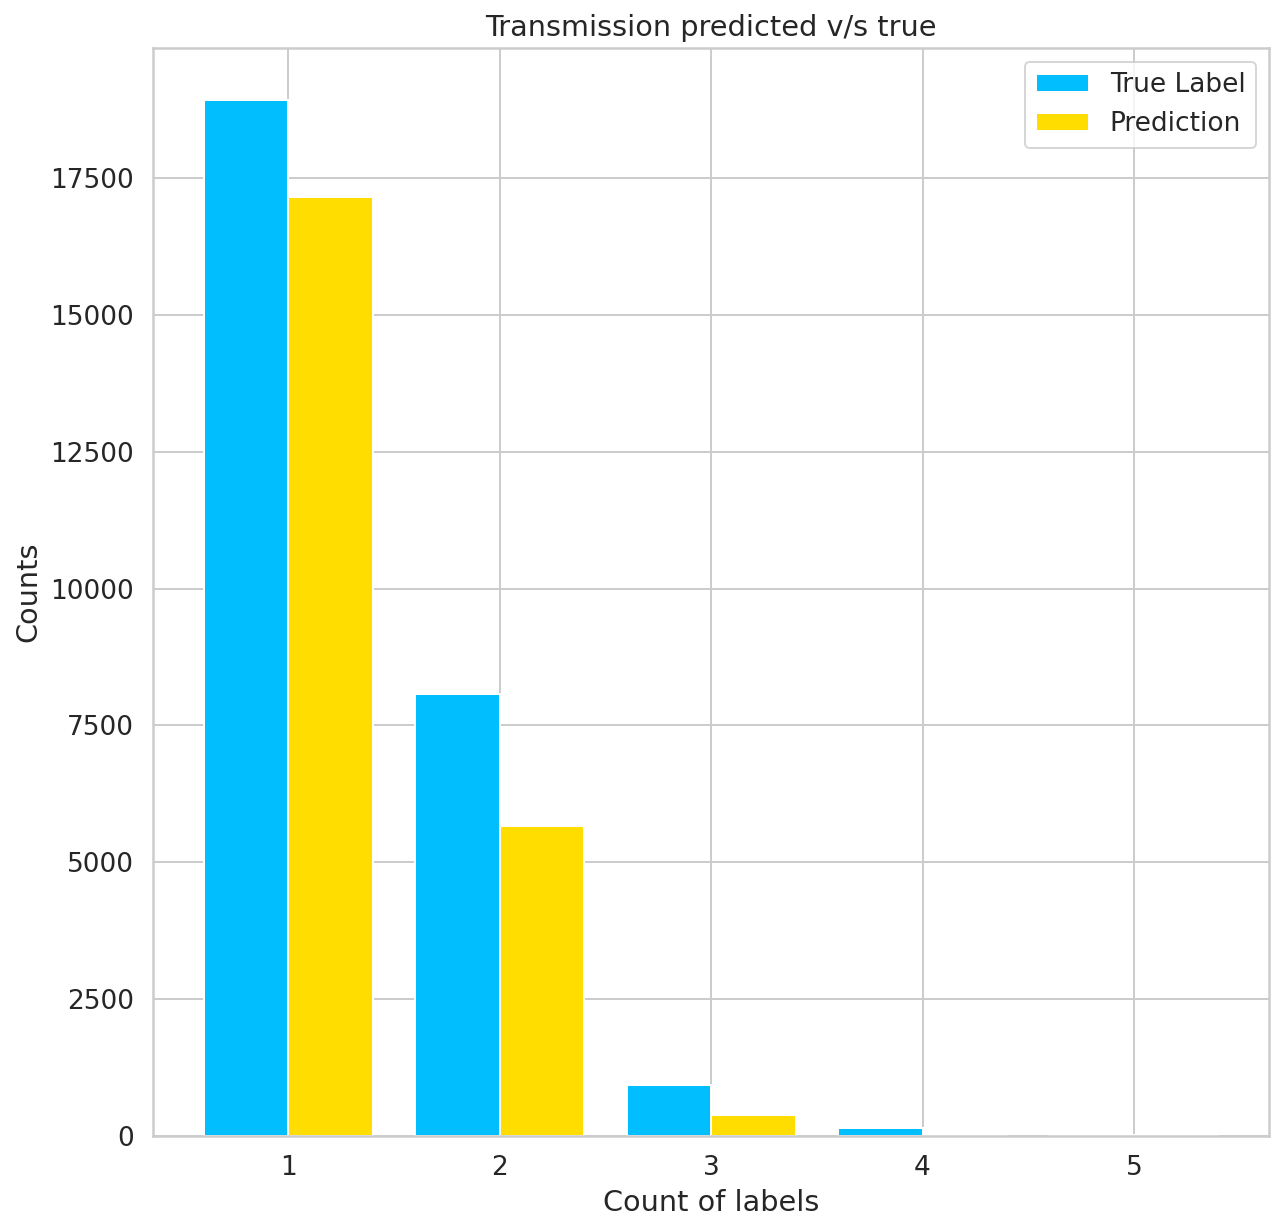

In [ ]:
X = ["1", "2", "3", "4", "5"]

# creating the dataset 
keys = list(pred_count_dict.keys()) 
pred_values = list(pred_count_dict.values()) 
true_values = list(true_count_dict.values())

keys = np.array(keys)

fig = plt.figure(figsize = (10, 10)) 
  
# creating the bar plot 
plt.bar(keys - 0.2, true_values, 0.4, label = 'True Label')
plt.bar(keys + 0.2, pred_values, 0.4, label = 'Prediction')

plt.xticks(keys, X)
plt.xlabel("Count of labels")
plt.ylabel("Counts")
plt.title("Transmission predicted v/s true")
plt.legend()
plt.show() 

In [ ]:
class_dict_pred = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_true = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_pred, class_dict_true

({'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0},
 {'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0})

In [ ]:
THRESHOLD = 0.5
print(LABEL_COLUMNS)

for item in val_dataset:

  labels = item["labels"].numpy()
  count = np.count_nonzero(labels)

  if count == 2:
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )

    # print((prediction > THRESHOLD).type(torch.uint8))

    prediction = prediction.cpu()

    for idx, key in enumerate(class_dict_pred.keys()):

      class_dict_pred[key] += (prediction[0, idx] > THRESHOLD).type(torch.uint8)

    for idx, key in enumerate(class_dict_true.keys()):
      class_dict_true[key] += labels[idx]

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
for key, value in class_dict_pred.items():

  class_dict_pred[key] = value.numpy().item()

print(class_dict_pred)
print(class_dict_true)

{'Case Report': 2, 'Diagnosis': 112, 'Epidemic Forecasting': 52, 'Mechanism': 45, 'Prevention': 18, 'Transmission': 3, 'Treatment': 21}
{'Case Report': 0.0, 'Diagnosis': 119.0, 'Epidemic Forecasting': 19.0, 'Mechanism': 129.0, 'Prevention': 482.0, 'Transmission': 755.0, 'Treatment': 6.0}


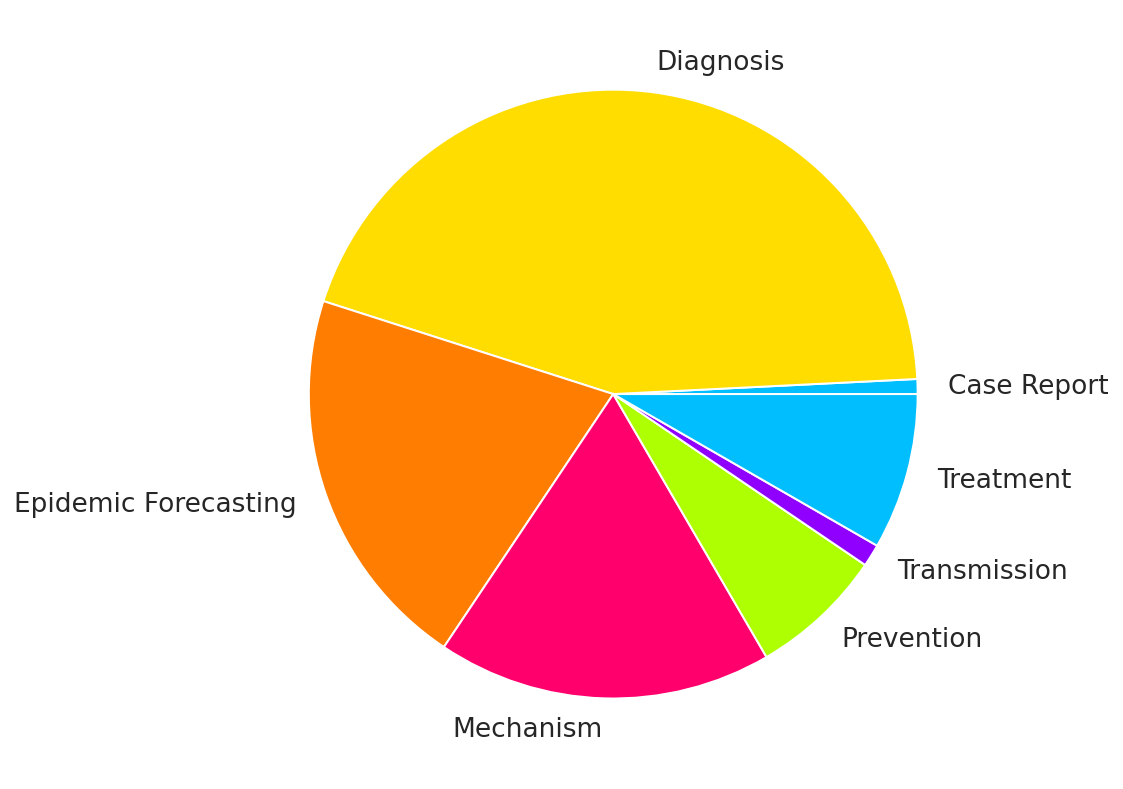

In [ ]:
keys = class_dict_pred.keys()
values = class_dict_pred.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
  
# show plot
plt.show()

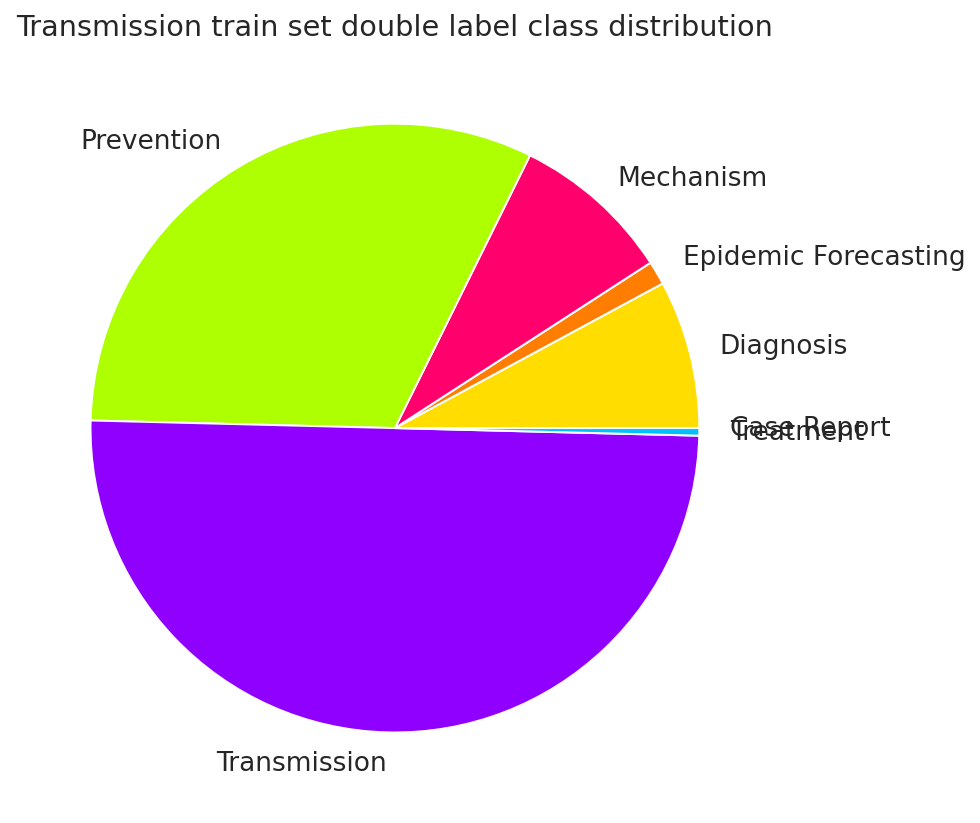

In [ ]:
keys = class_dict_true.keys()
values = class_dict_true.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
plt.title("Transmission train set double label class distribution")
# show plot
plt.show()

#### Accuracy

In [ ]:
THRESHOLD = 0.5

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9401)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9876385927200317
Diagnosis: 0.9692410230636597
Epidemic Forecasting: 0.9884118437767029
Mechanism: 0.9760458469390869
Prevention: 0.9766302704811096
Transmission: 0.9689500331878662
Treatment: 0.9700363278388977


#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report       0.68      0.93      0.79       179
           Diagnosis       0.84      0.84      0.84       588
Epidemic Forecasting       0.85      0.76      0.80       128
           Mechanism       0.71      0.93      0.80       419
          Prevention       0.92      0.92      0.92      1105
        Transmission       0.43      0.84      0.57        94
           Treatment       0.85      0.91      0.88       812

           micro avg       0.82      0.90      0.85      3325
           macro avg       0.75      0.88      0.80      3325
        weighted avg       0.83      0.90      0.86      3325
         samples avg       0.85      0.92      0.87      3325



In [ ]:
THRESHOLD = [0.5, 0.55, 0.6, 0.65, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"Threshold: {threshold}")

  print(
      classification_report(
          y_true,
          y_pred,
          digits=4,
          target_names=LABEL_COLUMNS,
          zero_division=0
          )
      )

Threshold: 0.5
                      precision    recall  f1-score   support

         Case Report     0.9412    0.8266    0.8802       271
           Diagnosis     0.8040    0.8919    0.8457       805
Epidemic Forecasting     0.8036    0.8654    0.8333       156
           Mechanism     0.8866    0.8534    0.8697       614
          Prevention     0.9239    0.9305    0.9272      1539
        Transmission     0.7893    0.8602    0.8232       379
           Treatment     0.8447    0.9295    0.8851      1106

           micro avg     0.8653    0.9008    0.8827      4870
           macro avg     0.8562    0.8796    0.8663      4870
        weighted avg     0.8680    0.9008    0.8832      4870
         samples avg     0.8920    0.9179    0.8897      4870

Threshold: 0.55
                      precision    recall  f1-score   support

         Case Report     0.9409    0.8229    0.8780       271
           Diagnosis     0.8168    0.8807    0.8476       805
Epidemic Forecasting     0.8133    

In [ ]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [ ]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [ ]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

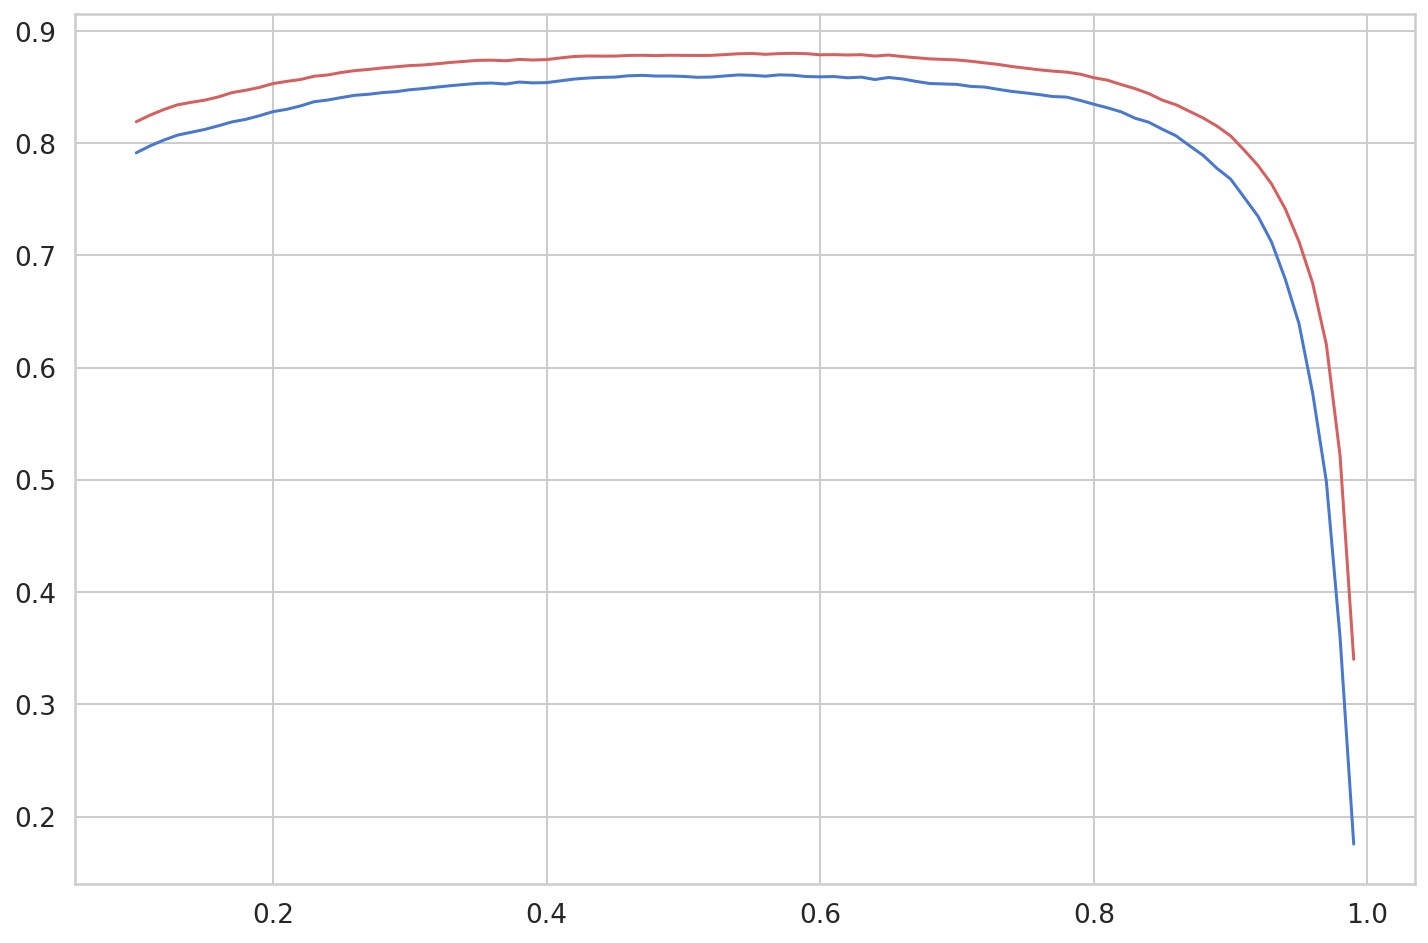

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [ ]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[48]

(0.8800578034682082, 48, 0.58)